In [2]:
#https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
def one_hot(train, test):
    len_train = train.shape[0]
    out = pd.DataFrame(np.concatenate((test, train), axis = 0))
    one_hot = pd.get_dummies(out, columns=[0])
    train_one_hot = one_hot.iloc[:len_train]
    test_one_hot = one_hot.iloc[len_train:]
    return np.array(train_one_hot), np.array(test_one_hot)

In [4]:
def import_data(file_name, test_split, separator, bool_front, bool_one_hot_X):
    data = pd.read_csv(file_name, sep = separator)
    X_Y_train_val, X_Y_test = train_test_split(data, test_size=test_split)
    if bool_front == True:
        X_train_val = X_Y_train_val.iloc[:, :-1]
        Y_train_val = X_Y_train_val.iloc[:,-1]
        X_test = X_Y_test.iloc[:, :-1]
        Y_test = X_Y_test.iloc[:,-1]
    else:
        X_train_val = X_Y_train_val.iloc[:, 0:]
        Y_train_val = X_Y_train_val.iloc[:,0]
        X_test = X_Y_test.iloc[:, 0:]
        Y_test = X_Y_test.iloc[:,0]
    if bool_one_hot_X == True:
        X_train_val, X_test = one_hot(X_train_val, X_test)
    else:
        X_train_val = np.array(X_train_val)
        X_test = np.array(X_test) 
    Y_train_val, Y_test = one_hot(Y_train_val, Y_test)
    return X_train_val, Y_train_val, X_test, Y_test

In [5]:
def next_batch(X, Y, batch_size, batch_number, max_batch_number, randint):
    np.random.seed(randint)
    np.random.shuffle(np.array(X))
    np.random.shuffle(np.array(Y))
    batch_X = X[:batch_size,:]
    batch_Y = Y[:batch_size,:]
    return batch_X, batch_Y

In [6]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [7]:
def nn(data_name, separator, train_test_split, learning_rate, training_epochs, batch_size, n_hidden, display_step, momentum, ac_list, bool_true, bool_one_hot_X):

    X_train_val, Y_train_val, X_test, Y_test = import_data(data_name, train_test_split, separator, bool_true, bool_one_hot_X)

    n_input = X_train_val.shape[1]
    n_classes = Y_train_val.shape[1]

    n_hidden_1 = n_hidden # 1st layer number of neurons
    n_hidden_2 = n_hidden # 2nd layer number of neurons# MNIST data input (img shape: 28*28)

    # tf Graph input
    X = tf.placeholder("float", [None, n_input])
    Y = tf.placeholder("float", [None, n_classes])
    
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    # Construct model
    logits = multilayer_perceptron(X, weights, biases)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum = momentum)
    train_op = optimizer.minimize(loss_op)
    # Initializing the variables
    init = tf.global_variables_initializer()
    test_ac = []
    train_ac = []

    with tf.Session() as sess:
        sess.run(init)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(X_train_val.shape[0]/batch_size)
            # Loop over all batches
            for i in range(total_batch):
                batch_x, batch_y = next_batch(X_train_val, Y_train_val, batch_size, i, total_batch, np.random.randint(1000))
                # Run optimization op (backprop) and cost op (to get loss value
                _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x,
                                                            Y: batch_y})
                # Compute average loss
                avg_cost += c / total_batch
            #shuffle epoch
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
            # test model
            pred = tf.nn.softmax( logits )
            correct_prediction = tf.equal( tf.argmax( pred, 1 ), tf.argmax( Y, 1 ) )
            
            # calculating accuracy
            accuracy = tf.reduce_mean( tf.cast( correct_prediction, "float" ) )
            train_ac.append(accuracy.eval( { X: X_train_val, Y: Y_train_val } ))
            test_ac.append(accuracy.eval( { X: X_test, Y: Y_test } ))
        print("Optimization Finished!")
    
        # Test model
        pred = tf.nn.softmax(logits)  # Apply softmax to logits
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

    n = 1
    plt.plot( train_ac )
    plt.title( "Training Accuracy vs Epoch" )
    plt.ylabel( "Accuracy" )
    plt.xlabel( "Epoch" )
    plt.grid()
    plt.show()
    n = n + 1
        
    plt.plot( test_ac )
    plt.title( "Testing Accuracy vs Epoch" )
    plt.ylabel( "Accuracy" )
    plt.xlabel( "Epoch" )
    plt.grid()
    plt.show()
    n = n + 1

    print("max test", np.max(test_ac))
    print("max train @ max test", train_ac[np.argmax(test_ac)])
    ac_list.append(np.max(test_ac))

Hidden Units:  1
Momentum:  0
Optimization Finished!
Accuracy: 0.0375


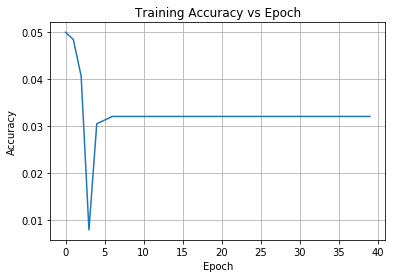

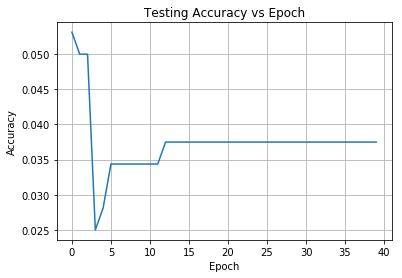

max test 0.053125
max train @ max test 0.050039094
Hidden Units:  1
Momentum:  0.2
Optimization Finished!
Accuracy: 0.0125


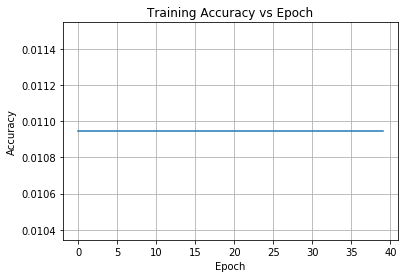

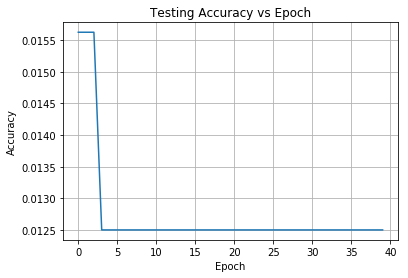

max test 0.015625
max train @ max test 0.010946051
Hidden Units:  1
Momentum:  0.5
Optimization Finished!
Accuracy: 0.34375


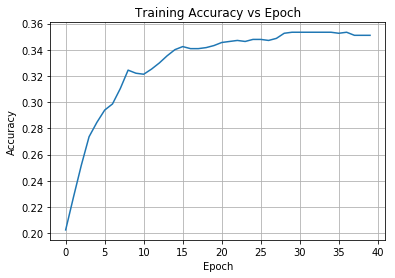

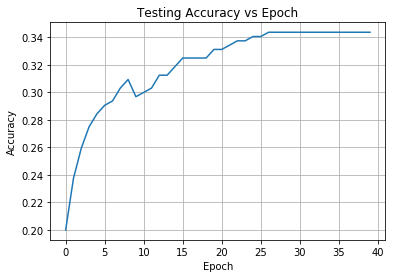

max test 0.34375
max train @ max test 0.3471462
Hidden Units:  1
Momentum:  0.9
Optimization Finished!
Accuracy: 0.35


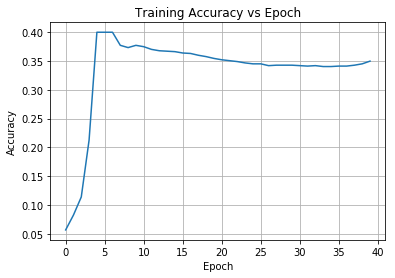

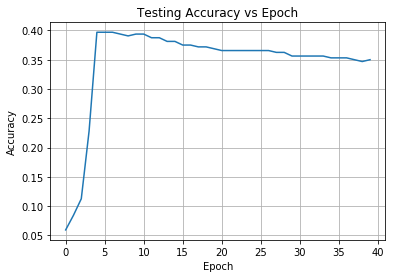

max test 0.396875
max train @ max test 0.3995309
Hidden Units:  2
Momentum:  0
Optimization Finished!
Accuracy: 0.134375


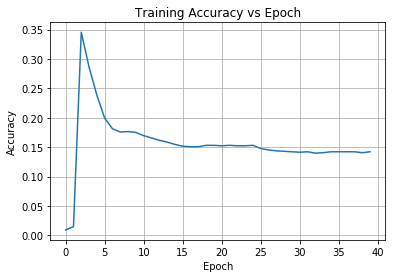

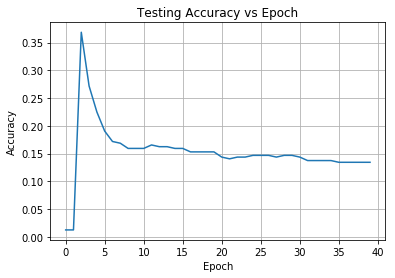

max test 0.36875
max train @ max test 0.3455825
Hidden Units:  2
Momentum:  0.2
Optimization Finished!
Accuracy: 0.125


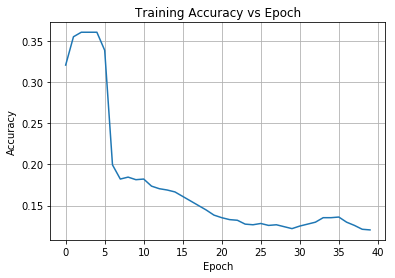

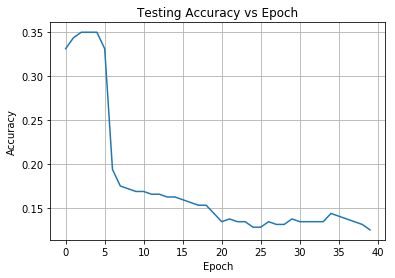

max test 0.35
max train @ max test 0.36043784
Hidden Units:  2
Momentum:  0.5
Optimization Finished!
Accuracy: 0.165625


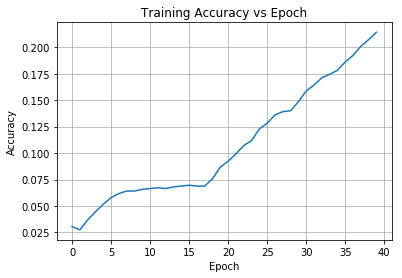

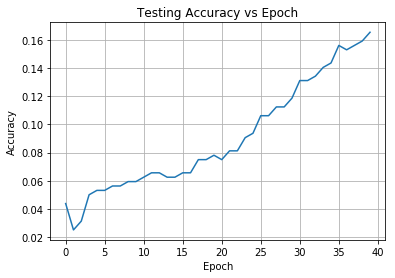

max test 0.165625
max train @ max test 0.21422987
Hidden Units:  2
Momentum:  0.9
Optimization Finished!
Accuracy: 0.3875


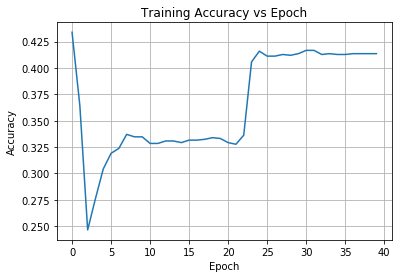

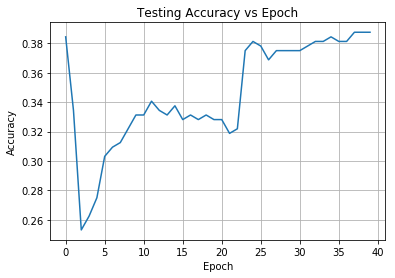

max test 0.3875
max train @ max test 0.41360438
Hidden Units:  4
Momentum:  0
Optimization Finished!
Accuracy: 0.31875


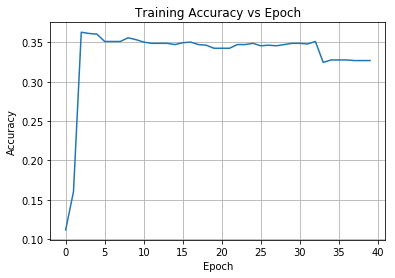

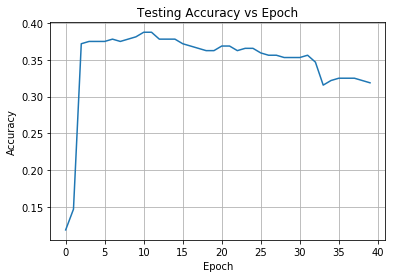

max test 0.3875
max train @ max test 0.35027364
Hidden Units:  4
Momentum:  0.2
Optimization Finished!
Accuracy: 0.403125


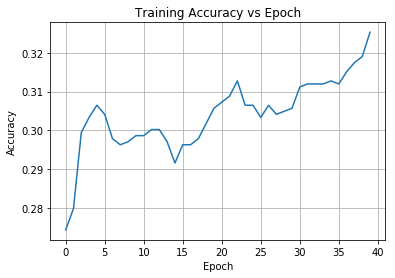

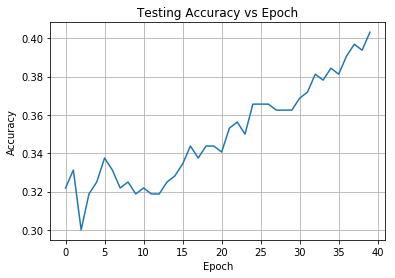

max test 0.403125
max train @ max test 0.3252541
Hidden Units:  4
Momentum:  0.5
Optimization Finished!
Accuracy: 0.2875


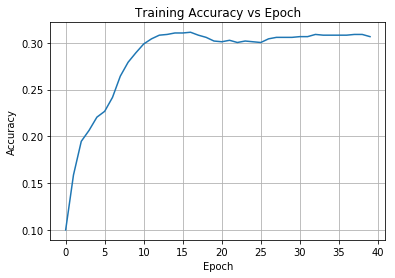

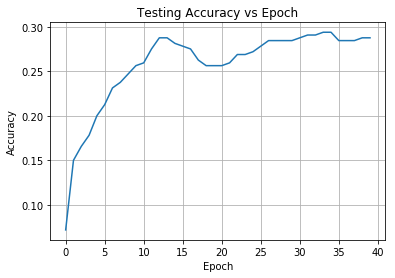

max test 0.29375
max train @ max test 0.30805317
Hidden Units:  4
Momentum:  0.9
Optimization Finished!
Accuracy: 0.35


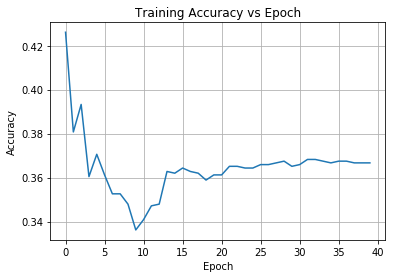

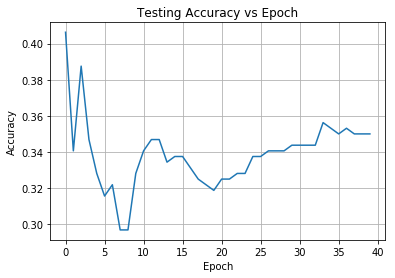

max test 0.40625
max train @ max test 0.42611414
Hidden Units:  8
Momentum:  0
Optimization Finished!
Accuracy: 0.353125


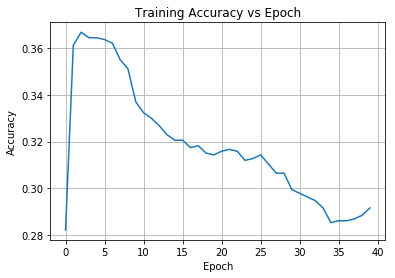

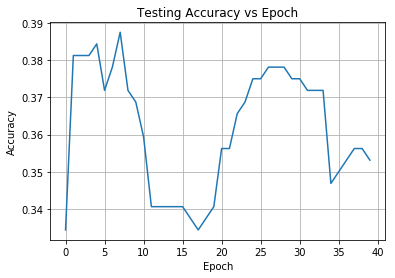

max test 0.3875
max train @ max test 0.35496482
Hidden Units:  8
Momentum:  0.2
Optimization Finished!
Accuracy: 0.3125


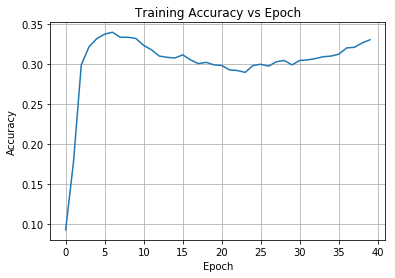

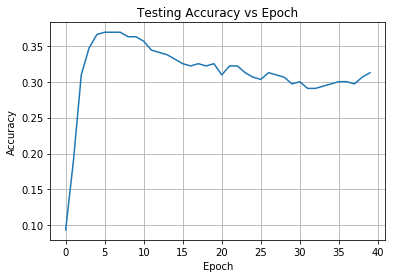

max test 0.36875
max train @ max test 0.336982
Hidden Units:  8
Momentum:  0.5
Optimization Finished!
Accuracy: 0.325


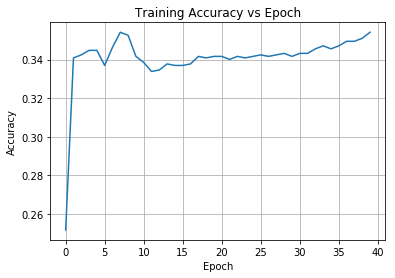

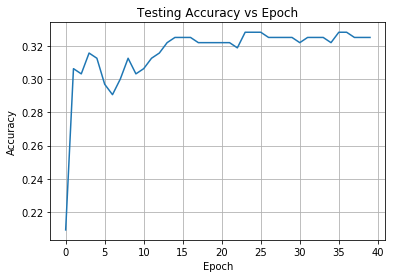

max test 0.328125
max train @ max test 0.34089133
Hidden Units:  8
Momentum:  0.9
Optimization Finished!
Accuracy: 0.3


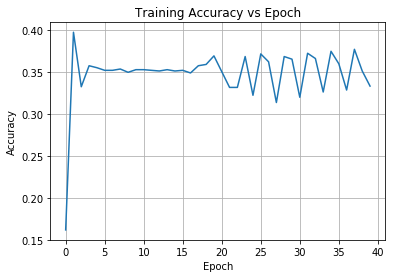

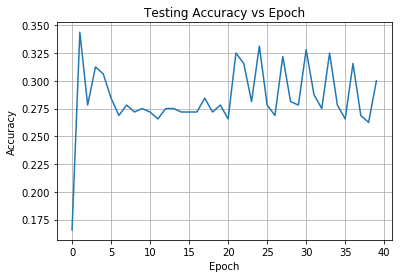

max test 0.34375
max train @ max test 0.3971853
Hidden Units:  32
Momentum:  0
Optimization Finished!
Accuracy: 0.3125


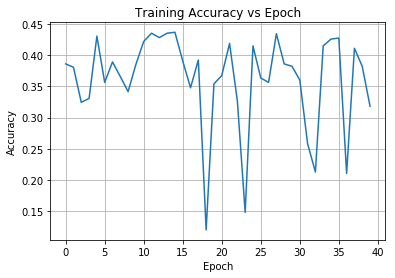

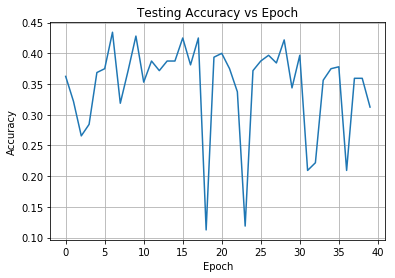

max test 0.434375
max train @ max test 0.3893667
Hidden Units:  32
Momentum:  0.2
Optimization Finished!
Accuracy: 0.375


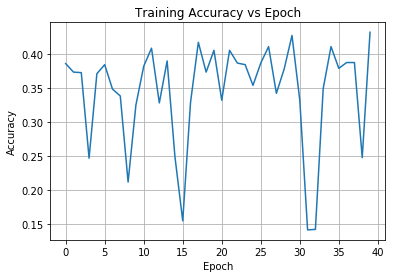

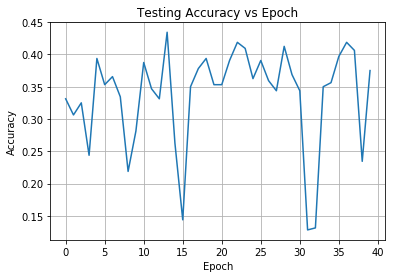

max test 0.434375
max train @ max test 0.39014855
Hidden Units:  32
Momentum:  0.5
Optimization Finished!
Accuracy: 0.38125


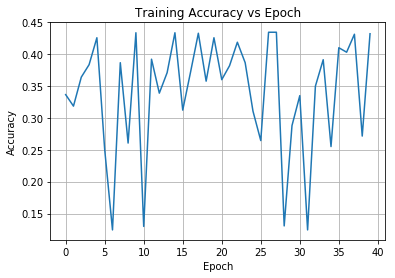

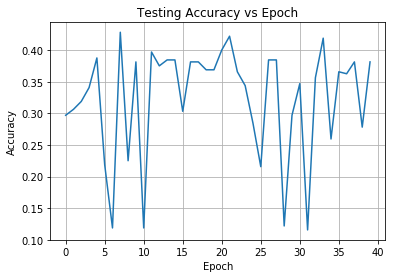

max test 0.428125
max train @ max test 0.38623926
Hidden Units:  32
Momentum:  0.9
Optimization Finished!
Accuracy: 0.31875


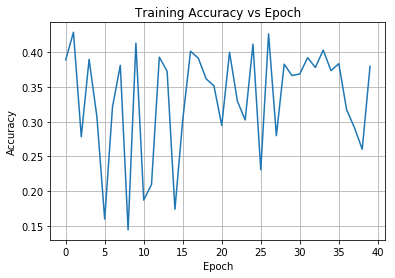

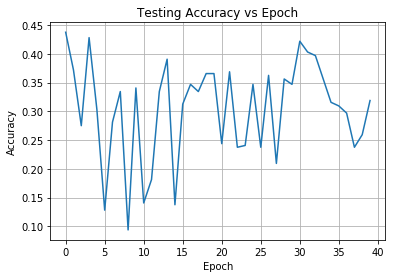

max test 0.4375
max train @ max test 0.3893667
Hidden Units:  128
Momentum:  0
Optimization Finished!
Accuracy: 0.121875


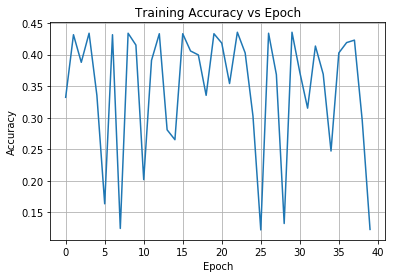

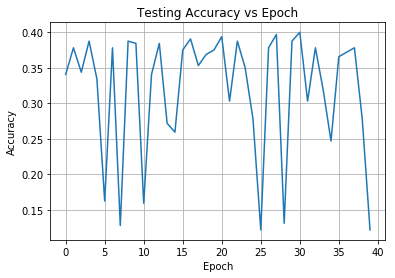

max test 0.4
max train @ max test 0.37216577
Hidden Units:  128
Momentum:  0.2
Optimization Finished!
Accuracy: 0.371875


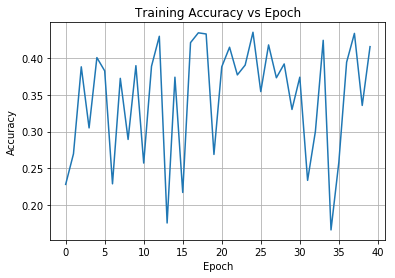

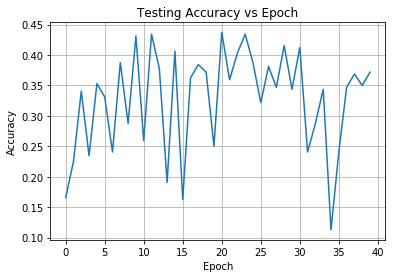

max test 0.4375
max train @ max test 0.38780296
Hidden Units:  128
Momentum:  0.5
Optimization Finished!
Accuracy: 0.240625


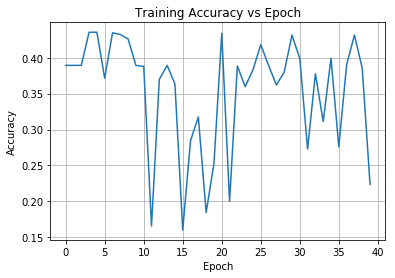

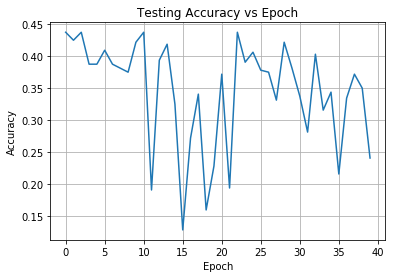

max test 0.4375
max train @ max test 0.3893667
Hidden Units:  128
Momentum:  0.9
Optimization Finished!
Accuracy: 0.35


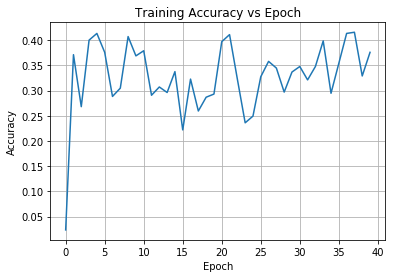

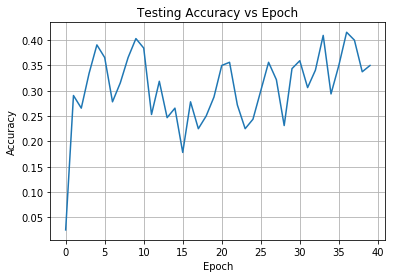

max test 0.415625
max train @ max test 0.41360438


In [9]:
# do the rest with the different hyperparameters, this si for winequality
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j  in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("winequality-red.csv", ";", 0.2, 0.0001, 40, 100, i, 1, j, ac_list, True, False)

In [10]:
out = np.argmax(np.array(ac_list)) +1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Opt Hidden Units:  128
Opt Momentum:  0.9
Maximum Test Accuracy:  0.4375


Hidden Units:  1
Momentum:  0
Optimization Finished!
Accuracy: 0.0023923444


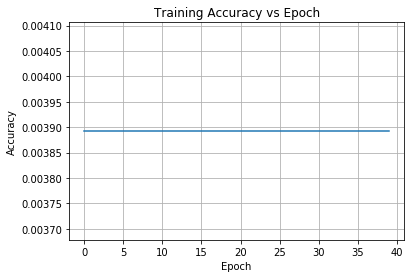

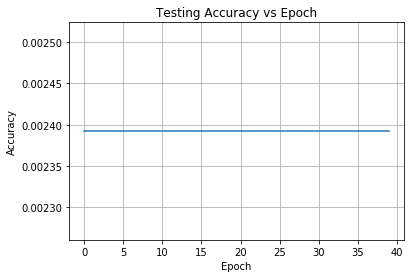

max test 0.0023923444
max train @ max test 0.0038922157
Hidden Units:  1
Momentum:  0.2
Optimization Finished!
Accuracy: 0.02631579


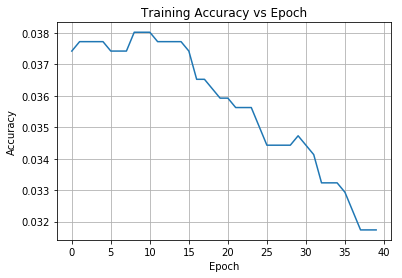

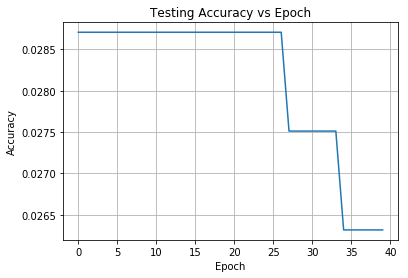

max test 0.028708134
max train @ max test 0.03742515
Hidden Units:  1
Momentum:  0.5
Optimization Finished!
Accuracy: 0.051435407


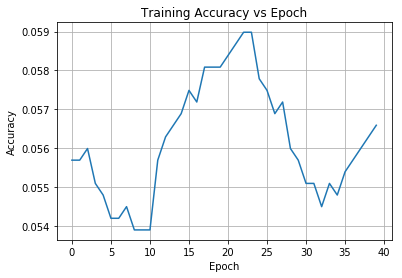

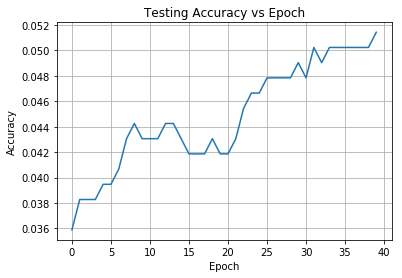

max test 0.051435407
max train @ max test 0.056586828
Hidden Units:  1
Momentum:  0.9
Optimization Finished!
Accuracy: 0.0


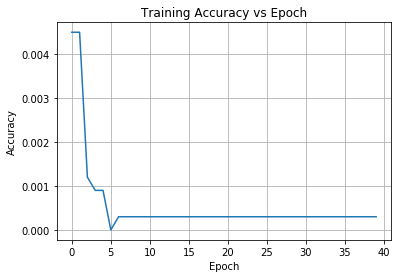

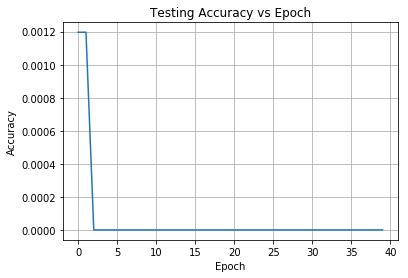

max test 0.0011961722
max train @ max test 0.004491018
Hidden Units:  2
Momentum:  0
Optimization Finished!
Accuracy: 0.02631579


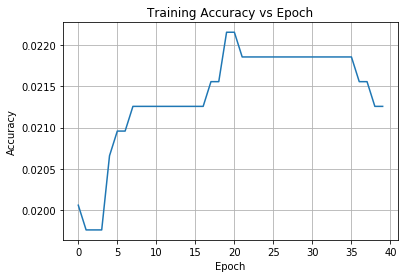

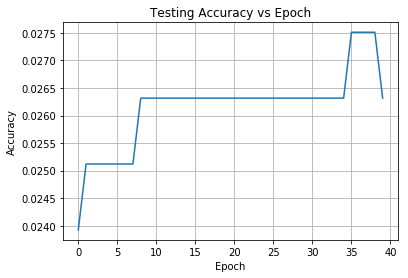

max test 0.027511962
max train @ max test 0.021856287
Hidden Units:  2
Momentum:  0.2
Optimization Finished!
Accuracy: 0.11244019


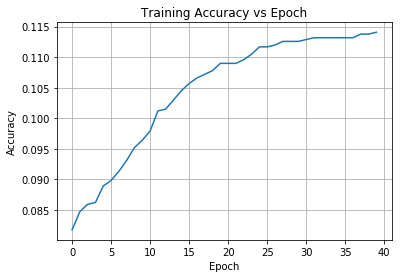

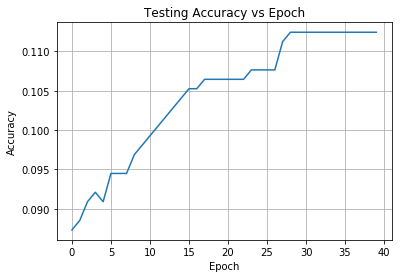

max test 0.11244019
max train @ max test 0.11257485
Hidden Units:  2
Momentum:  0.5
Optimization Finished!
Accuracy: 0.013157895


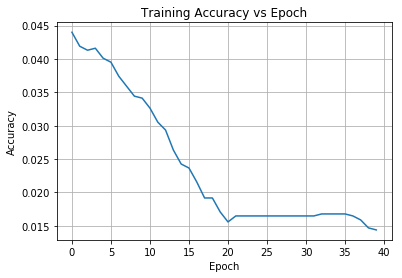

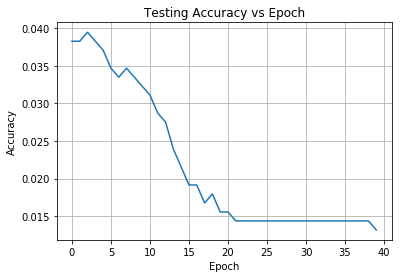

max test 0.039473683
max train @ max test 0.041317366
Hidden Units:  2
Momentum:  0.9
Optimization Finished!
Accuracy: 0.13636364


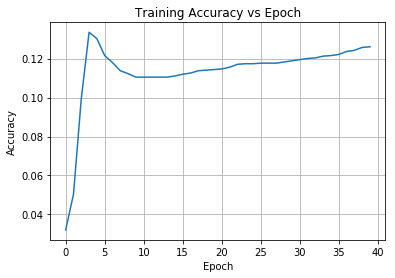

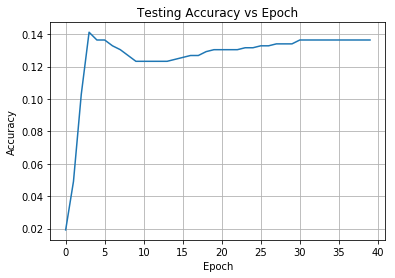

max test 0.14114833
max train @ max test 0.13353294
Hidden Units:  4
Momentum:  0
Optimization Finished!
Accuracy: 0.08014354


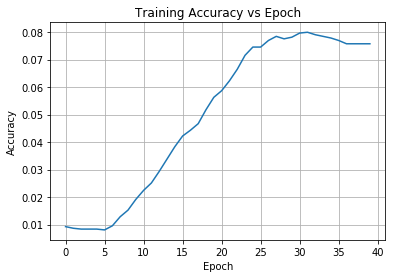

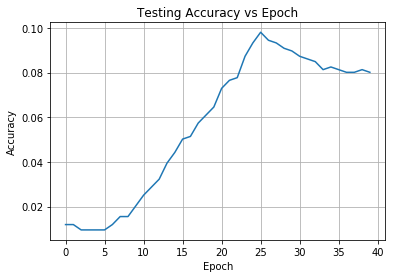

max test 0.098086126
max train @ max test 0.0745509
Hidden Units:  4
Momentum:  0.2
Optimization Finished!
Accuracy: 0.015550239


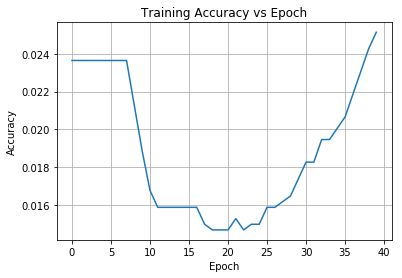

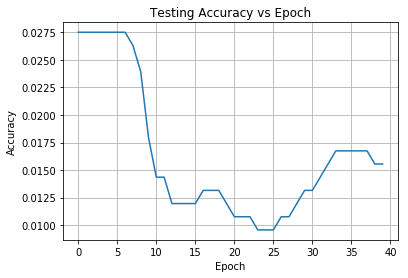

max test 0.027511962
max train @ max test 0.023652695
Hidden Units:  4
Momentum:  0.5
Optimization Finished!
Accuracy: 0.08492823


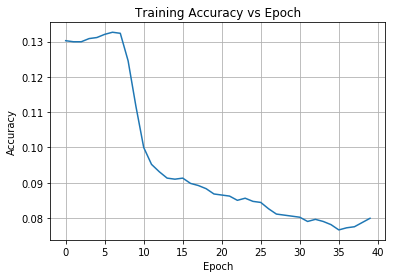

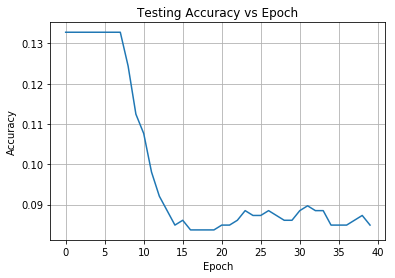

max test 0.13277511
max train @ max test 0.13023952
Hidden Units:  4
Momentum:  0.9
Optimization Finished!
Accuracy: 0.08492823


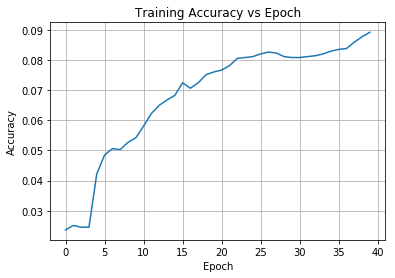

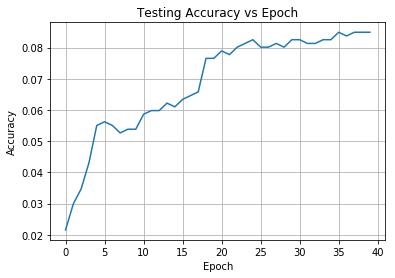

max test 0.08492823
max train @ max test 0.08353294
Hidden Units:  8
Momentum:  0
Optimization Finished!
Accuracy: 0.08373206


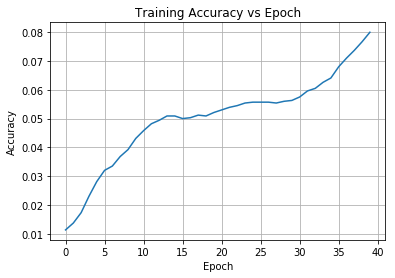

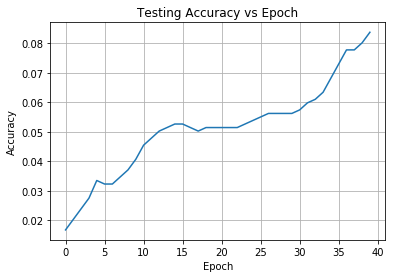

max test 0.08373206
max train @ max test 0.07994012
Hidden Units:  8
Momentum:  0.2
Optimization Finished!
Accuracy: 0.04784689


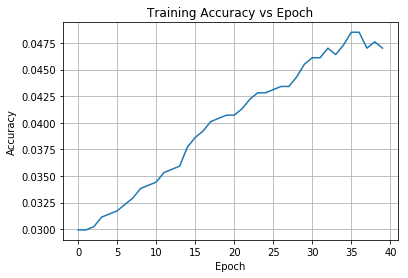

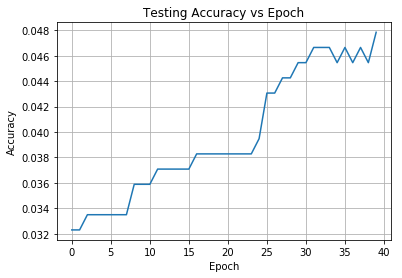

max test 0.04784689
max train @ max test 0.04700599
Hidden Units:  8
Momentum:  0.5
Optimization Finished!
Accuracy: 0.09330144


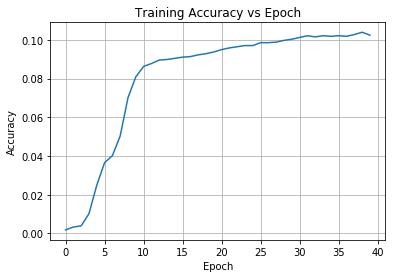

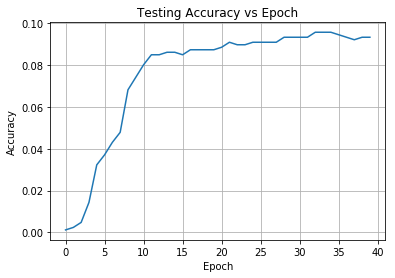

max test 0.09569378
max train @ max test 0.10149701
Hidden Units:  8
Momentum:  0.9
Optimization Finished!
Accuracy: 0.15789473


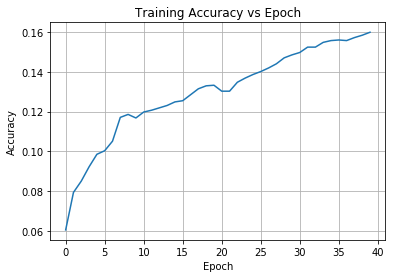

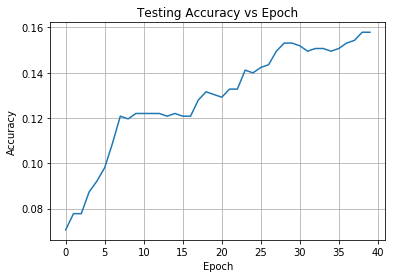

max test 0.15789473
max train @ max test 0.15838324
Hidden Units:  32
Momentum:  0
Optimization Finished!
Accuracy: 0.12200957


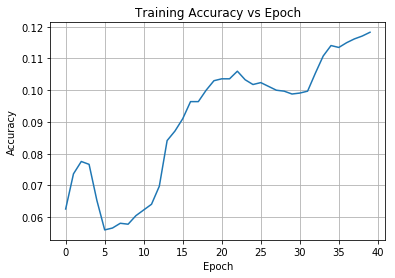

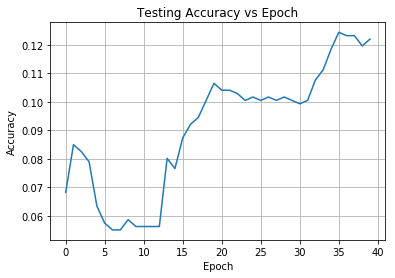

max test 0.12440191
max train @ max test 0.11347305
Hidden Units:  32
Momentum:  0.2
Optimization Finished!
Accuracy: 0.16626795


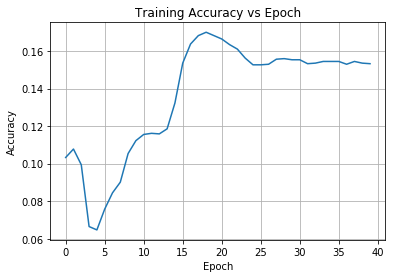

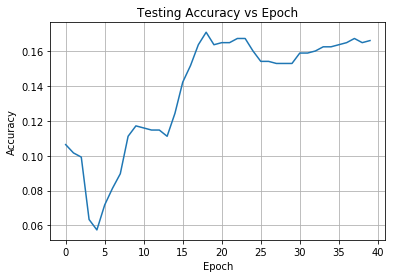

max test 0.17105263
max train @ max test 0.17005987
Hidden Units:  32
Momentum:  0.5
Optimization Finished!
Accuracy: 0.1555024


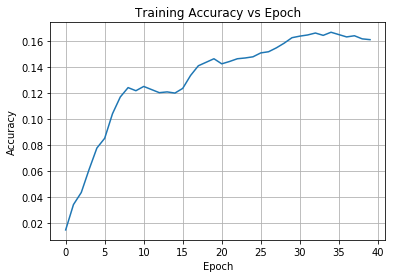

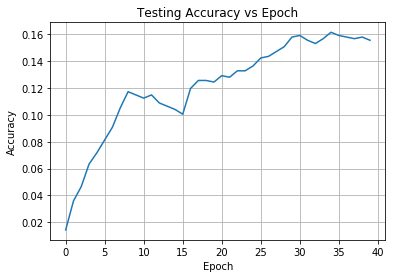

max test 0.16148326
max train @ max test 0.16676646
Hidden Units:  32
Momentum:  0.9
Optimization Finished!
Accuracy: 0.20574163


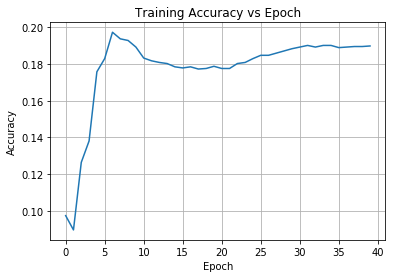

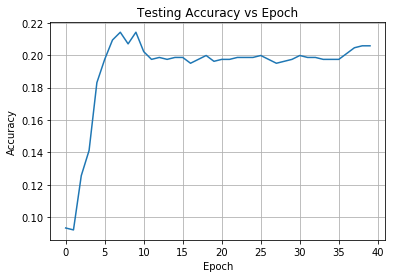

max test 0.21411483
max train @ max test 0.19371258
Hidden Units:  128
Momentum:  0
Optimization Finished!
Accuracy: 0.16985646


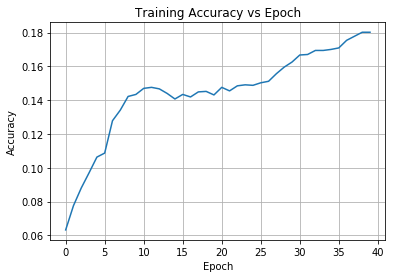

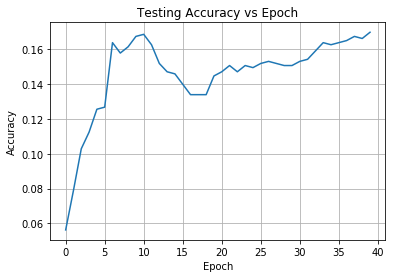

max test 0.16985646
max train @ max test 0.18023951
Hidden Units:  128
Momentum:  0.2
Optimization Finished!
Accuracy: 0.13157895


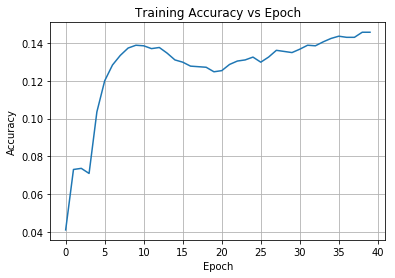

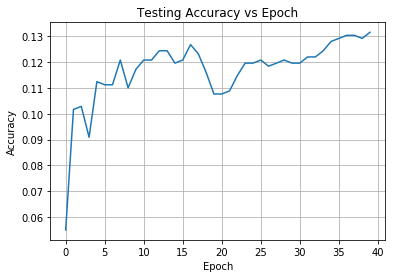

max test 0.13157895
max train @ max test 0.14580838
Hidden Units:  128
Momentum:  0.5
Optimization Finished!
Accuracy: 0.21052632


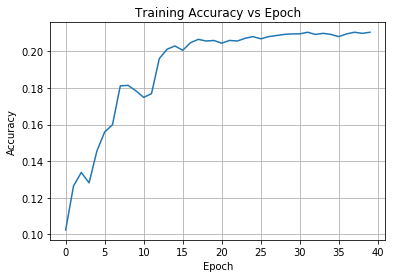

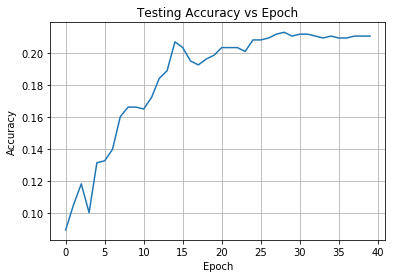

max test 0.21291865
max train @ max test 0.20928144
Hidden Units:  128
Momentum:  0.9
Optimization Finished!
Accuracy: 0.20574163


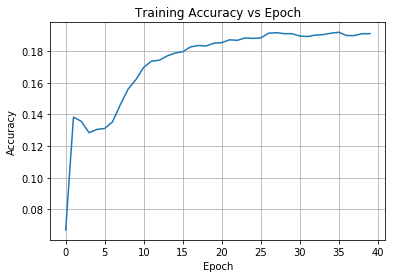

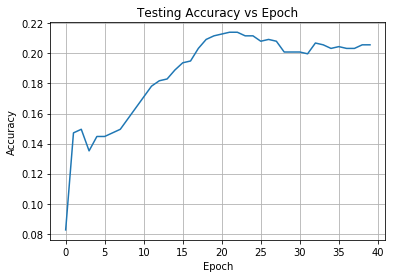

max test 0.21411483
max train @ max test 0.18712574


In [11]:
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("abalone.data", ",", 0.2, 0.0001, 40, 100, i, 1, j, ac_list, True, True)

In [12]:
out = np.argmax(np.array(ac_list)) +1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Opt Hidden Units:  128
Opt Momentum:  0.9
Maximum Test Accuracy:  0.21411483


In [1]:
# do the rest with the different hyperparameters, this si for winequality
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j  in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("SUSY.csv", ",", 0.2, 0.01, 1, 1000, i, 1, j, ac_list, False, False)

Hidden Units:  1
Momentum:  0


NameError: name 'nn' is not defined

In [10]:
out = np.argmax(np.array(ac_list)) + 1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Opt Hidden Units:  1
Opt Momentum:  0.2
Maximum Test Accuracy:  0.5429
